In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap, cross_val_score_scratch, export_imodels_for_SHAP

In [3]:
# Import other libraries
import pandas as pd
import numpy as np
import numbers
import matplotlib.pyplot as plt
import matplotlib as mpl
from imodels import HSTreeClassifier, HSTreeRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
import shap

In [4]:
# Gloabl figure settings
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Strobl Simulation 

We replicate the simulation design used by where a binary response variable Y is predicted from a set of 5 predictor variables that vary in their scale of measurement and number of categories. The first predictor variable X1 is continuous, while the other predictor variables  X2,…,X5  are multinomial with  2,4,10,20  categories, respectively. The sample size for all simulation studies was set to n = 120. In the first all predictor variables and the response are sampled independently. We would hope that a reasonable variable importance measure would not prefer any one predictor variable over any other. In the second simulation study, the so-called power study, the distribution of the response is a binomial process with probabilities that depend on the value of  x2 , namely  P(y=1|X2=1)=0.35,P(y=1|X2=2)=0.65  .

## Define functions to simulate data

In [158]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [63]:
def simulate_data_simple(n=120, M=100, relevance_power=0.15, imp_score="MDI", reg_param=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    featimp_sk_null = []
    featimp_im_null = []
    featimp_scr_null = []
    featimp_scrHS_null = []
    featimp_sk_power = []
    featimp_im_power = []
    featimp_scr_power = []
    featimp_scrHS_power = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)   
    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)
    
    for i in range(M):
        
        #Fit sklearn
        clf_null_sk = DecisionTreeClassifier(random_state=random_seed).fit(X_null[i,:,:], y_null[:,i])
        if imp_score=="MDI":
            featimp_sk_null.append(clf_null_sk.feature_importances_)
        elif imp_score=="SHAP":
            explainer_null_sk = shap.TreeExplainer(clf_null_sk)
            shap_values_null_sk = explainer_null_sk.shap_values(X_null[i,:,:])[1] #only class 1 pred
            featimp_sk_null.append(shap_values_null_sk)
        #elif imp_score=="SmoothSHAP":
            

        #Fit imodels
        clf_null_im = HSTreeClassifier(deepcopy(clf_null_sk), reg_param=reg_param)
        if imp_score=="MDI":
            featimp_im_null.append(clf_null_im.estimator_.feature_importances_)
        elif imp_score=="SHAP":
            export_im_null = export_imodels_for_SHAP(clf_null_im, is_forest=False)
            explainer_im_null = shap.TreeExplainer(export_im_null)
            shap_values_im_null = explainer_im_null.shap_values(X_null[i,:,:])
            featimp_im_null.append(shap_values_im_null)
        #elif imp_score=="SmoothSHAP":
            

        #Fit scratch
        clf_null_scr = DecisionTree(treetype="classification", random_state=random_seed)
        clf_null_scr.fit(X_null[i,:,:], y_null[:,i])
        if imp_score=="MDI":
            featimp_scr_null.append(clf_null_scr.feature_importances_)
        elif imp_score=="SHAP":
            export_model_scr_null = clf_null_scr.export_tree_for_SHAP()
            explainer_scr_null = shap.TreeExplainer(export_model_scr_null)
            shap_values_scr_null = explainer_scr_null.shap_values(X_null[i,:,:])
            featimp_scr_null.append(shap_values_scr_null)
        #elif imp_score=="SmoothSHAP":
            
        
        #Fit scratch HS
        clf_null_scrHS = DecisionTree(treetype="classification", HShrinkage=True, HS_lambda=reg_param, random_state=random_seed)
        clf_null_scrHS.fit(X_null[i,:,:], y_null[:,i])
        if imp_score=="MDI":
            featimp_scrHS_null.append(clf_null_scrHS.feature_importances_)
        elif imp_score=="SHAP":
            export_model_scrHS_null = clf_null_scrHS.export_tree_for_SHAP()
            explainer_scrHS_null = shap.TreeExplainer(export_model_scrHS_null)
            shap_values_scrHS_null = explainer_scrHS_null.shap_values(X_null[i,:,:])
            featimp_scrHS_null.append(shap_values_scrHS_null)
        #elif imp_score=="SmoothSHAP":
            
        
        
        #Fit sklearn
        clf_power_sk = DecisionTreeClassifier(random_state=random_seed).fit(X_power[i,:,:], y_power[:,i])
        if imp_score=="MDI":
            featimp_sk_power.append(clf_power_sk.feature_importances_)
        elif imp_score=="SHAP":
            explainer_power_sk = shap.TreeExplainer(clf_power_sk)
            shap_values_power_sk = explainer_power_sk.shap_values(X_power[i,:,:])[1] #only class 1 pred
            featimp_sk_power.append(shap_values_power_sk)
        #elif imp_score=="SmoothSHAP":
            

        #Fit imodels
        clf_power_im = HSTreeClassifier(deepcopy(clf_power_sk), reg_param=reg_param)
        if imp_score=="MDI":
            featimp_im_power.append(clf_power_im.estimator_.feature_importances_)
        elif imp_score=="SHAP":
            export_im_power = export_imodels_for_SHAP(clf_power_im, is_forest=False)
            explainer_im_power = shap.TreeExplainer(export_im_power)
            shap_values_im_power = explainer_im_power.shap_values(X_power[i,:,:])
            featimp_im_power.append(shap_values_im_power)
        #elif imp_score=="SmoothSHAP":
            

        #Fit scratch
        clf_power_scr = DecisionTree(treetype="classification", random_state=random_seed)
        clf_power_scr.fit(X_power[i,:,:], y_power[:,i])
        if imp_score=="MDI":
            featimp_scr_power.append(clf_power_scr.feature_importances_)
        elif imp_score=="SHAP":
            export_model_scr_power = clf_power_scr.export_tree_for_SHAP()
            explainer_scr_power = shap.TreeExplainer(export_model_scr_power)
            shap_values_scr_power = explainer_scr_power.shap_values(X_power[i,:,:])
            featimp_scr_power.append(shap_values_scr_power)
        #elif imp_score=="SmoothSHAP":
            
        
        #Fit scratch HS
        clf_power_scrHS = DecisionTree(treetype="classification", HShrinkage=True, HS_lambda=reg_param, random_state=random_seed)
        clf_power_scrHS.fit(X_power[i,:,:], y_power[:,i])
        if imp_score=="MDI":
            featimp_scrHS_power.append(clf_power_scrHS.feature_importances_)
        elif imp_score=="SHAP":
            export_model_scrHS_power = clf_power_scrHS.export_tree_for_SHAP()
            explainer_scrHS_power = shap.TreeExplainer(export_model_scrHS_power)
            shap_values_scrHS_power = explainer_scrHS_power.shap_values(X_power[i,:,:])
            featimp_scrHS_power.append(shap_values_scrHS_power)
        #elif imp_score=="SmoothSHAP":
            
        
    
    feat_imps_null = [featimp_sk_null, featimp_im_null, featimp_scr_null, featimp_scrHS_null]
    feat_imps_power = [featimp_sk_power, featimp_im_power, featimp_scr_power, featimp_scrHS_power]
    
    return [X_null, y_null], [X_power, y_power], feat_imps_null, feat_imps_power


In [129]:
# for random forests and smooth shap
def simulate_data_simpleRF(n=120, M=100, n_trees=50, relevance_power=0.15, imp_score="MDI", reg_param=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    featimp_sk_null = []
    featimp_im_null = []
    featimp_scr_null = []
    featimp_scrHS_null = []
    featimp_sk_power = []
    featimp_im_power = []
    featimp_scr_power = []
    featimp_scrHS_power = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)   
    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_state)
    
    for i in range(M):
        
        #Fit sklearn
        if imp_score!="SmoothSHAP": #for now we only compute smoothshap for tree from scratch models
            
            clf_null_sk = RandomForestClassifier(n_estimators=n_trees, random_state=random_seed).fit(X_null[i,:,:], y_null[:,i])
            if imp_score=="MDI":
                featimp_sk_null.append(clf_null_sk.feature_importances_)
            elif imp_score=="SHAP":
                explainer_null_sk = shap.TreeExplainer(clf_null_sk)
                shap_values_null_sk = explainer_null_sk.shap_values(X_null[i,:,:])[1] #only class 1 pred
                featimp_sk_null.append(shap_values_null_sk)
            

        #Fit imodels
        if imp_score!="SmoothSHAP": #for now we only compute smoothshap for tree from scratch models

            clf_null_im = HSTreeClassifier(deepcopy(clf_null_sk), reg_param=reg_param)
            if imp_score=="MDI":
                featimp_im_null.append(clf_null_im.estimator_.feature_importances_)
            elif imp_score=="SHAP":
                export_im_null = export_imodels_for_SHAP(clf_null_im, is_forest=True)
                explainer_im_null = shap.TreeExplainer(export_im_null)
                shap_values_im_null = explainer_im_null.shap_values(X_null[i,:,:])
                featimp_im_null.append(shap_values_im_null)


        #Fit scratch
        clf_null_scr = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification",
                                    oob=True if imp_score !="MDI" else False, 
                                    oob_SHAP=True if imp_score !="MDI" else False, random_state=random_seed)
        clf_null_scr.fit(X_null[i,:,:], y_null[:,i])
        if imp_score=="MDI":
            featimp_scr_null.append(clf_null_scr.feature_importances_)
        else:
            shap_values_scr_null_inbag = clf_null_scr.inbag_SHAP_values
            shap_values_scr_null_oob = clf_null_scr.oob_SHAP_values
            
            if imp_score=="SHAP":
                featimp_scr_null.append([shap_values_scr_null_inbag, shap_values_scr_null_oob])
            elif imp_score=="SmoothSHAP":
                smooth_shap_vals_scr_null, _ = smooth_shap(
                    shap_values_scr_null_inbag, shap_values_scr_null_oob)
                featimp_scr_null.append(smooth_shap_vals_scr_null)
            
        
        #Fit scratch HS
        clf_null_scrHS = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification", 
                                      HShrinkage=True, HS_lambda=reg_param, oob=True if imp_score !="MDI" else False, 
                                      oob_SHAP=True if imp_score !="MDI" else False, random_state=random_seed)
        clf_null_scrHS.fit(X_null[i,:,:], y_null[:,i])
        if imp_score=="MDI":
            featimp_scrHS_null.append(clf_null_scrHS.feature_importances_)
        else:
            shap_values_scrHS_null_inbag = clf_null_scrHS.inbag_SHAP_values
            shap_values_scrHS_null_oob = clf_null_scrHS.oob_SHAP_values
                        
            if imp_score=="SHAP":
                featimp_scrHS_null.append([shap_values_scrHS_null_inbag, shap_values_scrHS_null_oob])
            elif imp_score=="SmoothSHAP":
                smooth_shap_vals_scrHS_null, _ = smooth_shap(
                    shap_values_scrHS_null_inbag, shap_values_scrHS_null_oob)
                featimp_scrHS_null.append(smooth_shap_vals_scrHS_null)
        
        
        #Fit sklearn
        if imp_score!="SmoothSHAP": #for now we only compute smoothshap for tree from scratch models

            clf_power_sk = clf_power_sk = RandomForestClassifier(n_estimators=n_trees, random_state=random_seed).fit(X_power[i,:,:], y_power[:,i])
            if imp_score=="MDI":
                featimp_sk_power.append(clf_power_sk.feature_importances_)
            elif imp_score=="SHAP":
                explainer_power_sk = shap.TreeExplainer(clf_power_sk)
                shap_values_power_sk = explainer_power_sk.shap_values(X_power[i,:,:])[1] #only class 1 pred
                featimp_sk_power.append(shap_values_power_sk)

        #Fit imodels
        if imp_score!="SmoothSHAP": #for now we only compute smoothshap for tree from scratch models
            
            clf_power_im = HSTreeClassifier(deepcopy(clf_power_sk), reg_param=reg_param)
            if imp_score=="MDI":
                featimp_im_power.append(clf_power_im.estimator_.feature_importances_)
            elif imp_score=="SHAP":
                export_im_power = export_imodels_for_SHAP(clf_power_im, is_forest=True)
                explainer_im_power = shap.TreeExplainer(export_im_power)
                shap_values_im_power = explainer_im_power.shap_values(X_power[i,:,:])
                featimp_im_power.append(shap_values_im_power)
            

        #Fit scratch
        clf_power_scr = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification", 
                                    oob=True if imp_score !="MDI" else False, 
                                    oob_SHAP=True if imp_score !="MDI" else False, random_state=random_seed)
        clf_power_scr.fit(X_power[i,:,:], y_power[:,i])
        if imp_score=="MDI":
            featimp_scr_power.append(clf_power_scr.feature_importances_)
        else:
            shap_values_scr_power_inbag = clf_power_scr.inbag_SHAP_values
            shap_values_scr_power_oob = clf_power_scr.oob_SHAP_values
            
            if imp_score=="SHAP":
                featimp_scr_power.append([shap_values_scr_power_inbag, shap_values_scr_power_oob])
            elif imp_score=="SmoothSHAP":
                smooth_shap_vals_scr_power, _ = smooth_shap(
                    shap_values_scr_power_inbag, shap_values_scr_power_oob)
                featimp_scr_power.append(smooth_shap_vals_scr_power)  
            
        
        #Fit scratch HS
        clf_power_scrHS = RandomForest(n_trees= n_trees, n_feature="sqrt", treetype="classification", 
                                        HShrinkage=True, HS_lambda=reg_param, 
                                        oob=True if imp_score !="MDI" else False, 
                                        oob_SHAP=True if imp_score !="MDI" else False, random_state=random_seed)
        clf_power_scrHS.fit(X_power[i,:,:], y_power[:,i])
        if imp_score=="MDI":
            featimp_scrHS_power.append(clf_power_scrHS.feature_importances_)
        else:
            shap_values_scrHS_power_inbag = clf_power_scrHS.inbag_SHAP_values
            shap_values_scrHS_power_oob = clf_power_scrHS.oob_SHAP_values
                        
            if imp_score=="SHAP":
                featimp_scrHS_power.append([shap_values_scrHS_power_inbag, shap_values_scrHS_power_oob])
            elif imp_score=="SmoothSHAP":
                smooth_shap_vals_scrHS_power, _ = smooth_shap(
                    shap_values_scrHS_power_inbag, shap_values_scrHS_power_oob)
                featimp_scrHS_power.append(smooth_shap_vals_scrHS_power)           
        
    
    feat_imps_null = [featimp_sk_null, featimp_im_null, featimp_scr_null, featimp_scrHS_null]
    feat_imps_power = [featimp_sk_power, featimp_im_power, featimp_scr_power, featimp_scrHS_power]
    
    return [X_null, y_null], [X_power, y_power], feat_imps_null, feat_imps_power


## DecisionTrees

### MDI

Let's start with a comparison of MDI feature importance between the sklearn, imodels and the TreeModelsfromScratch with and without HS. Since MDI is based on the purity of nodes and not on the node values, we expect to get identical results for trees with and without hierarchical shrinkage.

In [250]:
%%time
[X_null, y_null], [X_power, y_power], feat_imps_null, feat_imps_power = simulate_data_simple(imp_score="MDI", random_seed=None)

CPU times: user 1min 48s, sys: 717 ms, total: 1min 49s
Wall time: 1min 50s


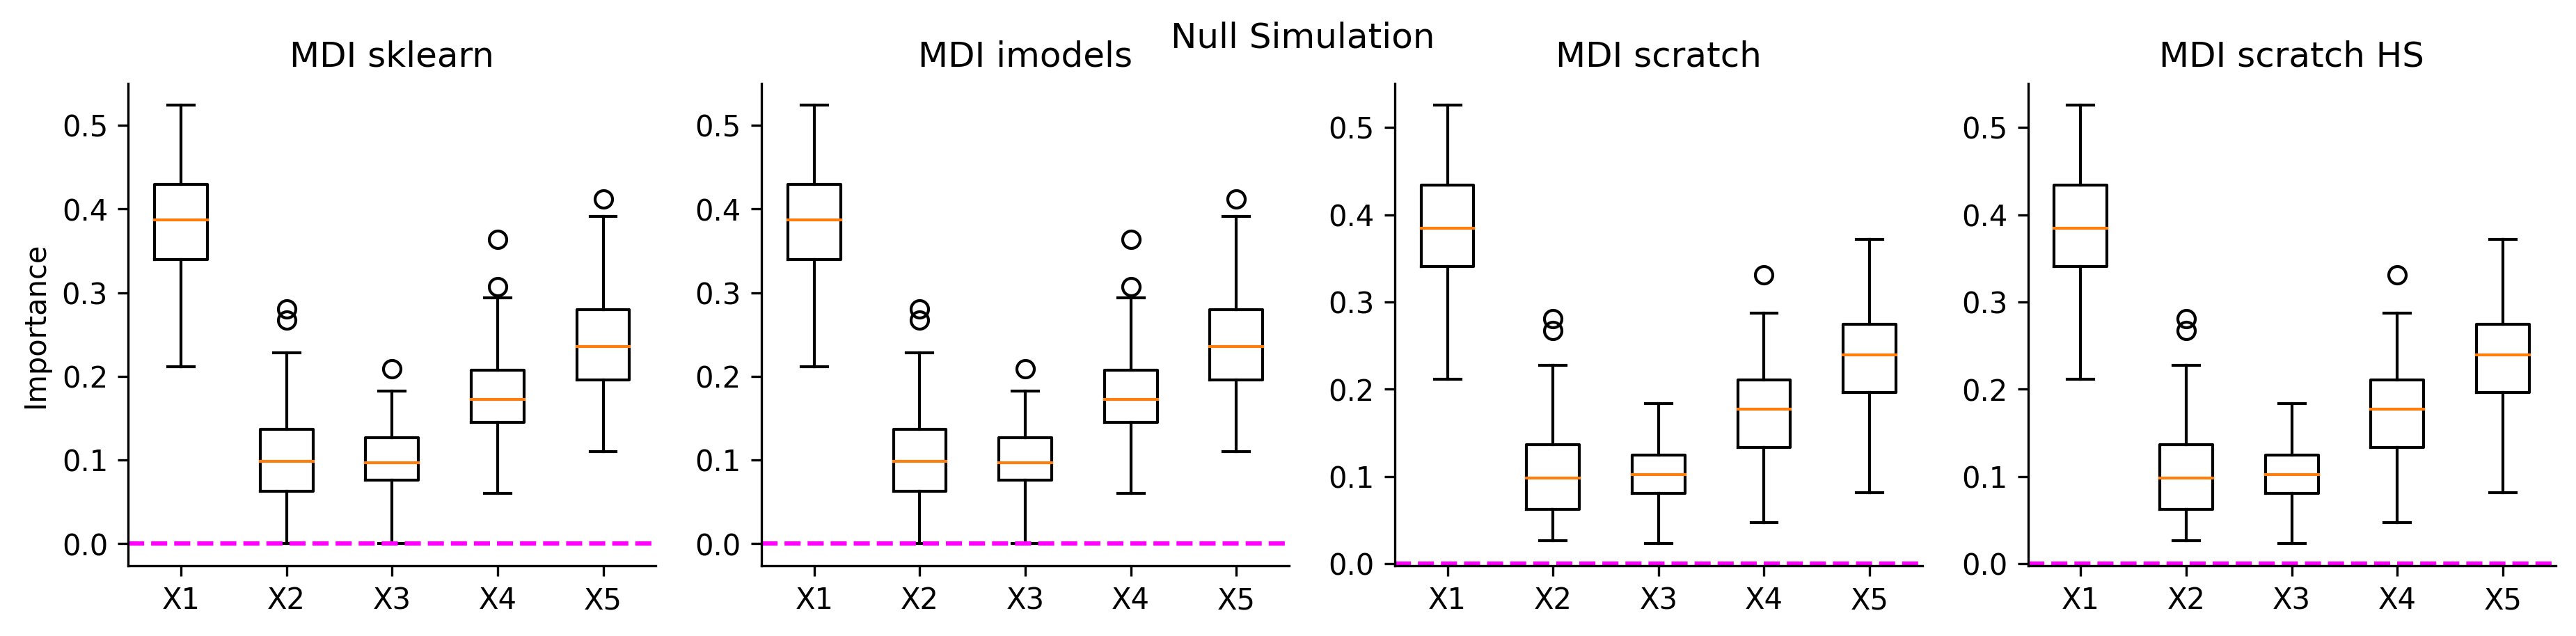

In [259]:
#Null simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,3))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation')           
axs1[0].boxplot(np.array(feat_imps_null[0]), labels=x_label)
axs1[0].axhline(y=0, color='magenta', linestyle='--')
axs1[0].set_title('MDI sklearn')
axs1[0].set_ylabel("Importance")
axs1[1].boxplot(np.array(feat_imps_null[1]), labels=x_label)
axs1[1].axhline(y=0, color='magenta', linestyle='--')
axs1[1].set_title('MDI imodels')
axs1[2].boxplot(np.array(feat_imps_null[2]), labels=x_label)
axs1[2].axhline(y=0, color='magenta', linestyle='--')
axs1[2].set_title('MDI scratch')
axs1[3].boxplot(np.array(feat_imps_null[3]), labels=x_label)
axs1[3].axhline(y=0, color='magenta', linestyle='--')
axs1[3].set_title('MDI scratch HS');

- As expected, the results of models with HS are identical to the ones without HS
- One can observe the well known bias of MDI in all of the 4 plots
- Also the TreeModelfromScratch package yields results which are ver similar to the ones from sklearn

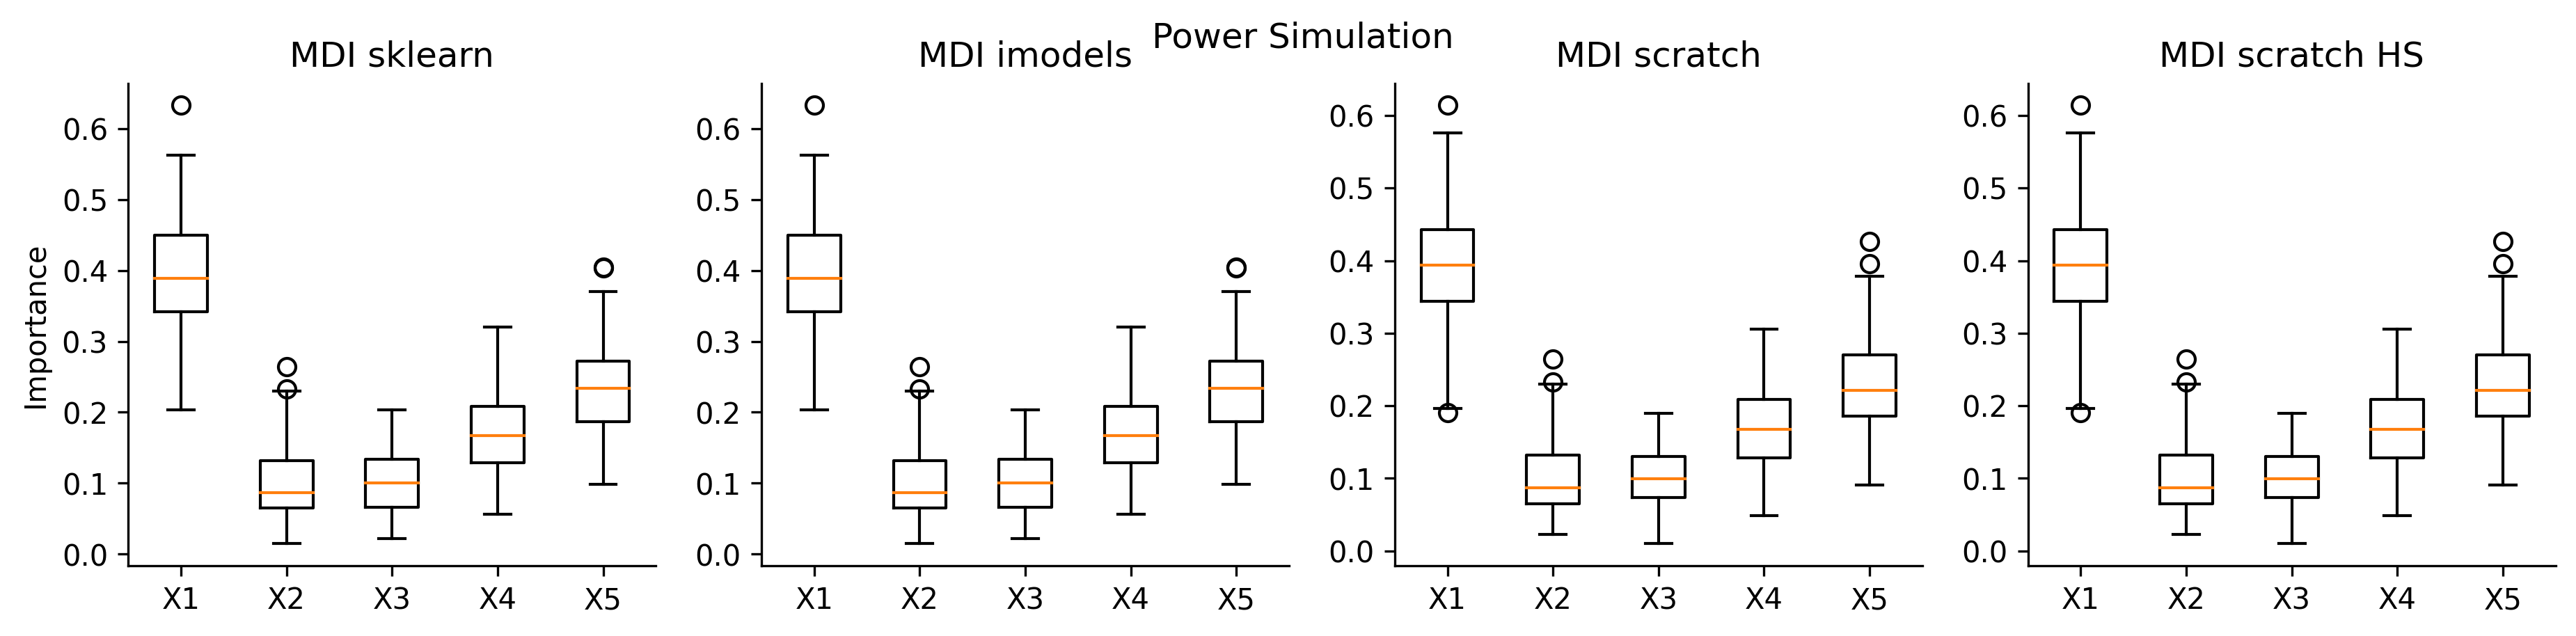

In [260]:
#Power simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,3))

fig.suptitle('Power Simulation')           
axs1[0].boxplot(np.array(feat_imps_power[0]), labels=x_label)
axs1[0].set_title('MDI sklearn')
axs1[0].set_ylabel('Importance')
axs1[1].boxplot(np.array(feat_imps_power[1]), labels=x_label)
axs1[1].set_title('MDI imodels')
axs1[2].boxplot(np.array(feat_imps_power[2]), labels=x_label)
axs1[2].set_title('MDI scratch')
axs1[3].boxplot(np.array(feat_imps_power[3]), labels=x_label)
axs1[3].set_title('MDI scratch HS');

- Interestingly, the results from the power simulation (where X2 is informative) appear to be very similar to the results from the null simulation. 
- For all models X2 gets very low MDI scores. The continuous feature (X1) and multinomial features with many categories yield the highest scores

### SHAP

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
%%time
[X_null, y_null], [X_power, y_power], shap_imps_null, shap_imps_power = simulate_data_simple(imp_score="SHAP", random_seed=None)

CPU times: user 1min 51s, sys: 1.15 s, total: 1min 52s
Wall time: 1min 55s


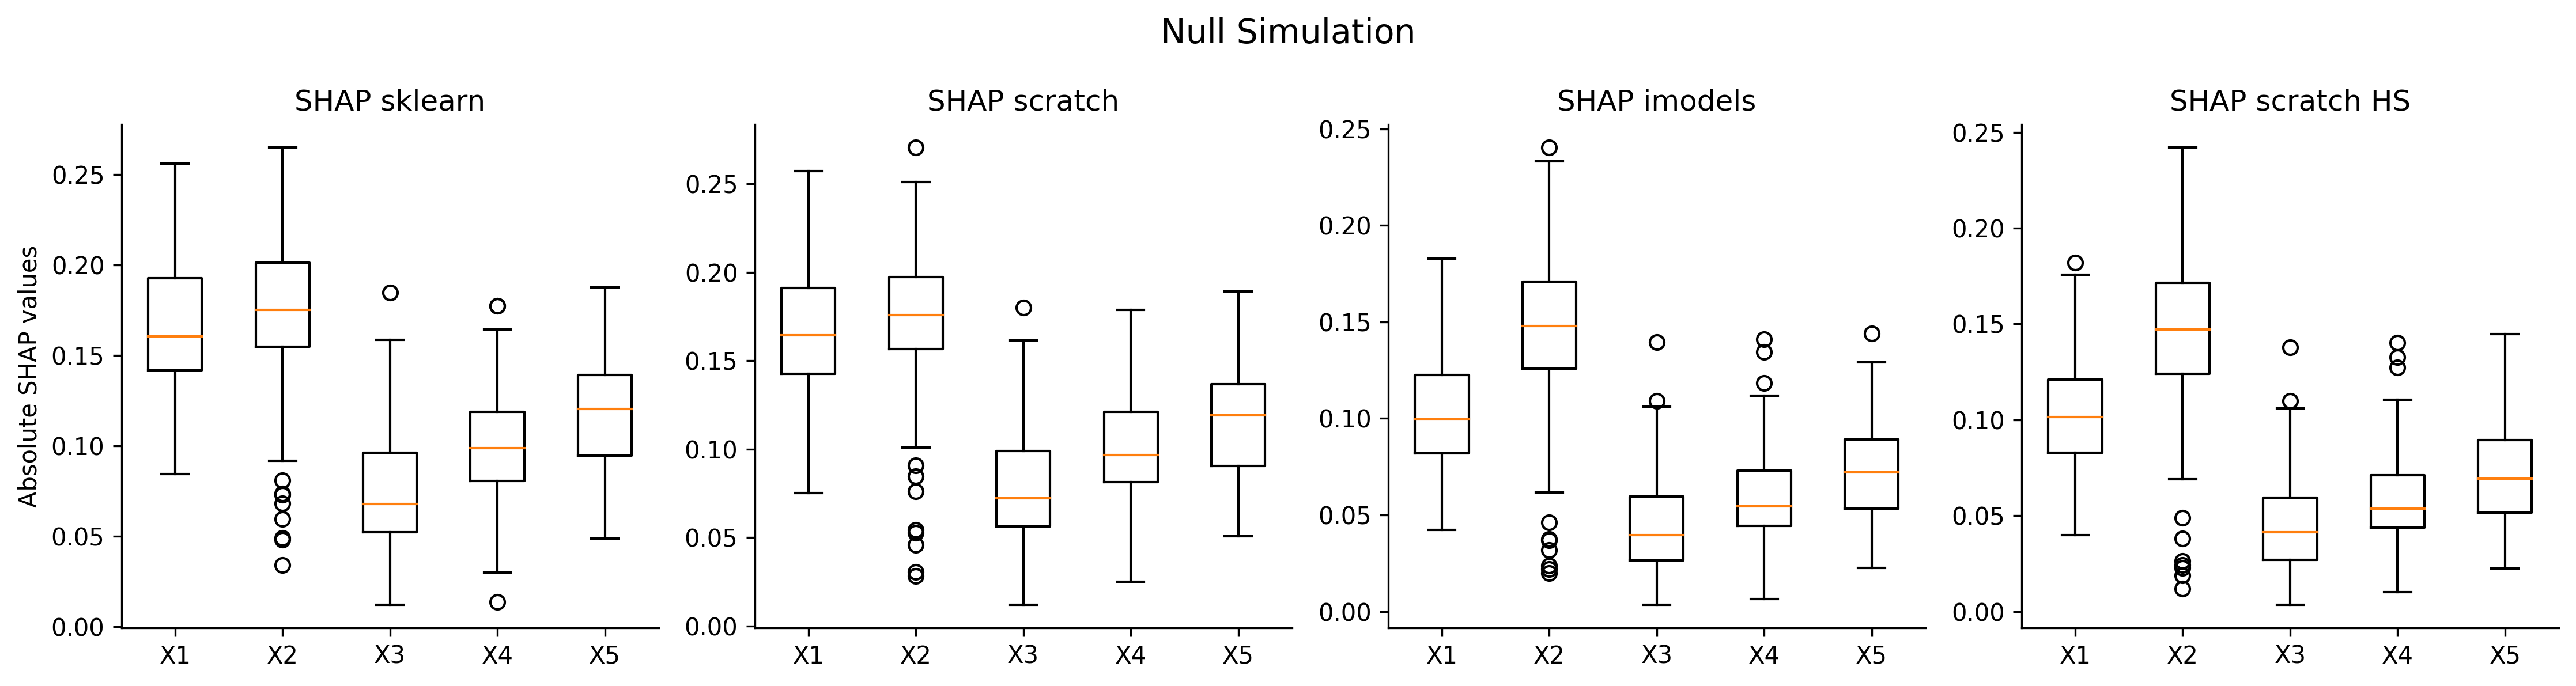

In [45]:
#Null simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,4))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation', fontsize=14)

axs1[0].boxplot(np.abs(np.array(shap_imps_null[0])).mean(axis=1), labels=x_label)
#axs1[0].axhline(y=0, color='magenta', linestyle='--')
axs1[0].set_title('SHAP sklearn')
axs1[0].set_ylabel("Absolute SHAP values")
axs1[1].boxplot(np.abs(np.array(shap_imps_null[2])).mean(axis=1), labels=x_label)
#axs1[1].axhline(y=0, color='magenta', linestyle='--')
axs1[1].set_title('SHAP scratch')
axs1[2].boxplot(np.abs(np.array(shap_imps_null[1])).mean(axis=1), labels=x_label)
#axs1[2].axhline(y=0, color='magenta', linestyle='--')
axs1[2].set_title('SHAP imodels')
axs1[3].boxplot(np.abs(np.array(shap_imps_null[3])).mean(axis=1), labels=x_label)
#axs1[3].axhline(y=0, color='magenta', linestyle='--')
axs1[3].set_title('SHAP scratch HS')

fig.tight_layout();

- The above plot shows the distribution of mean absolute SHAP values per feature across the 100 simulations. 
- The SHAP values for the both models with and without HS appear to be very similar 
- SHAP also shows a bias in its predictions. Interestingly, on average it tends to overestimate feature X2 the most
- The SHAP values for models with HS are shrunken

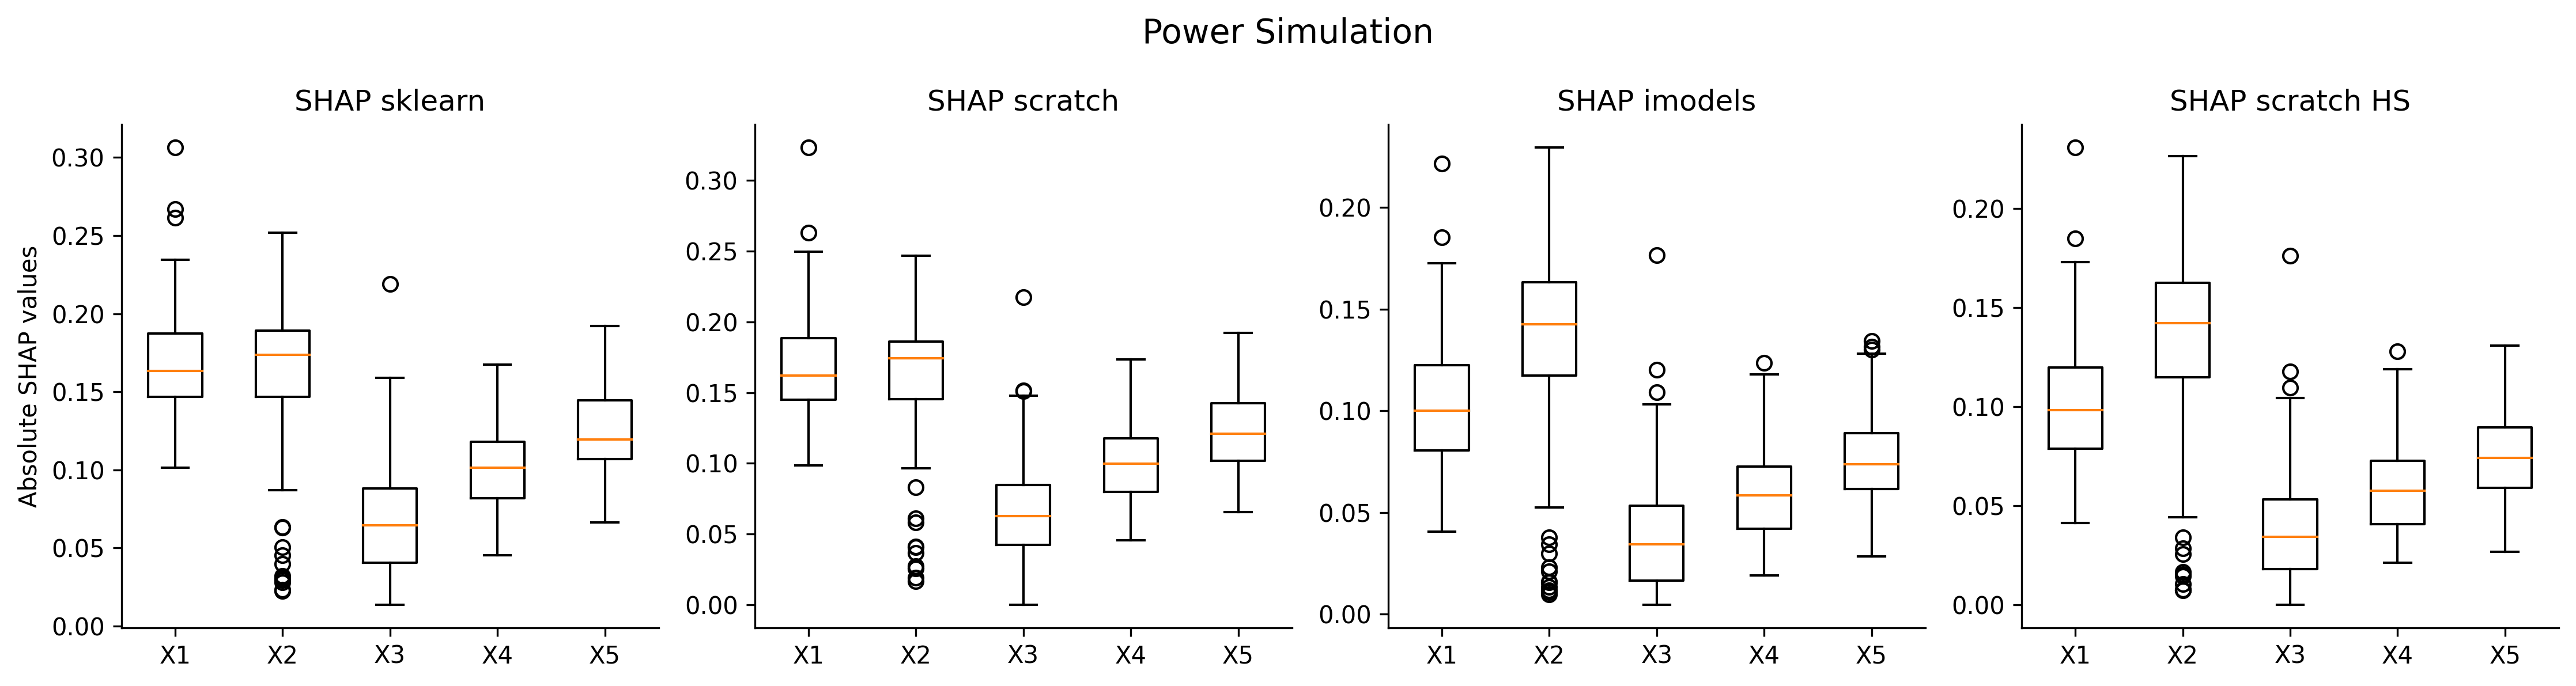

In [46]:
#Power simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,4))

fig.suptitle('Power Simulation', fontsize=14)

axs1[0].boxplot(np.abs(np.array(shap_imps_power[0])).mean(axis=1), labels=x_label)
axs1[0].set_title('SHAP sklearn')
axs1[0].set_ylabel('Absolute SHAP values')
axs1[1].boxplot(np.abs(np.array(shap_imps_power[2])).mean(axis=1), labels=x_label)
axs1[1].set_title('SHAP scratch')
axs1[2].boxplot(np.abs(np.array(shap_imps_power[1])).mean(axis=1), labels=x_label)
axs1[2].set_title('SHAP imodels')
axs1[3].boxplot(np.abs(np.array(shap_imps_power[3])).mean(axis=1), labels=x_label)
axs1[3].set_title('SHAP scratch HS')

fig.tight_layout();

- The SHAP values for the both models with and without HS appear to be very similar 
- SHAP for models without HS can not identify X2 as informative feature
- The SHAP values for models with HS show a small separation between the X2 and the other features. But still there is a lot of overlap

## RandomForests

### MDI

In [58]:
%%time
[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], feat_imps_nullRF, feat_imps_powerRF = simulate_data_simpleRF(
    n_trees=15, imp_score="MDI", random_seed=42)

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
1 out of 120 samples do not have OOB scores. This probably means too f

CPU times: user 5min 38s, sys: 4.5 s, total: 5min 43s
Wall time: 5min 49s


1 out of 120 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score


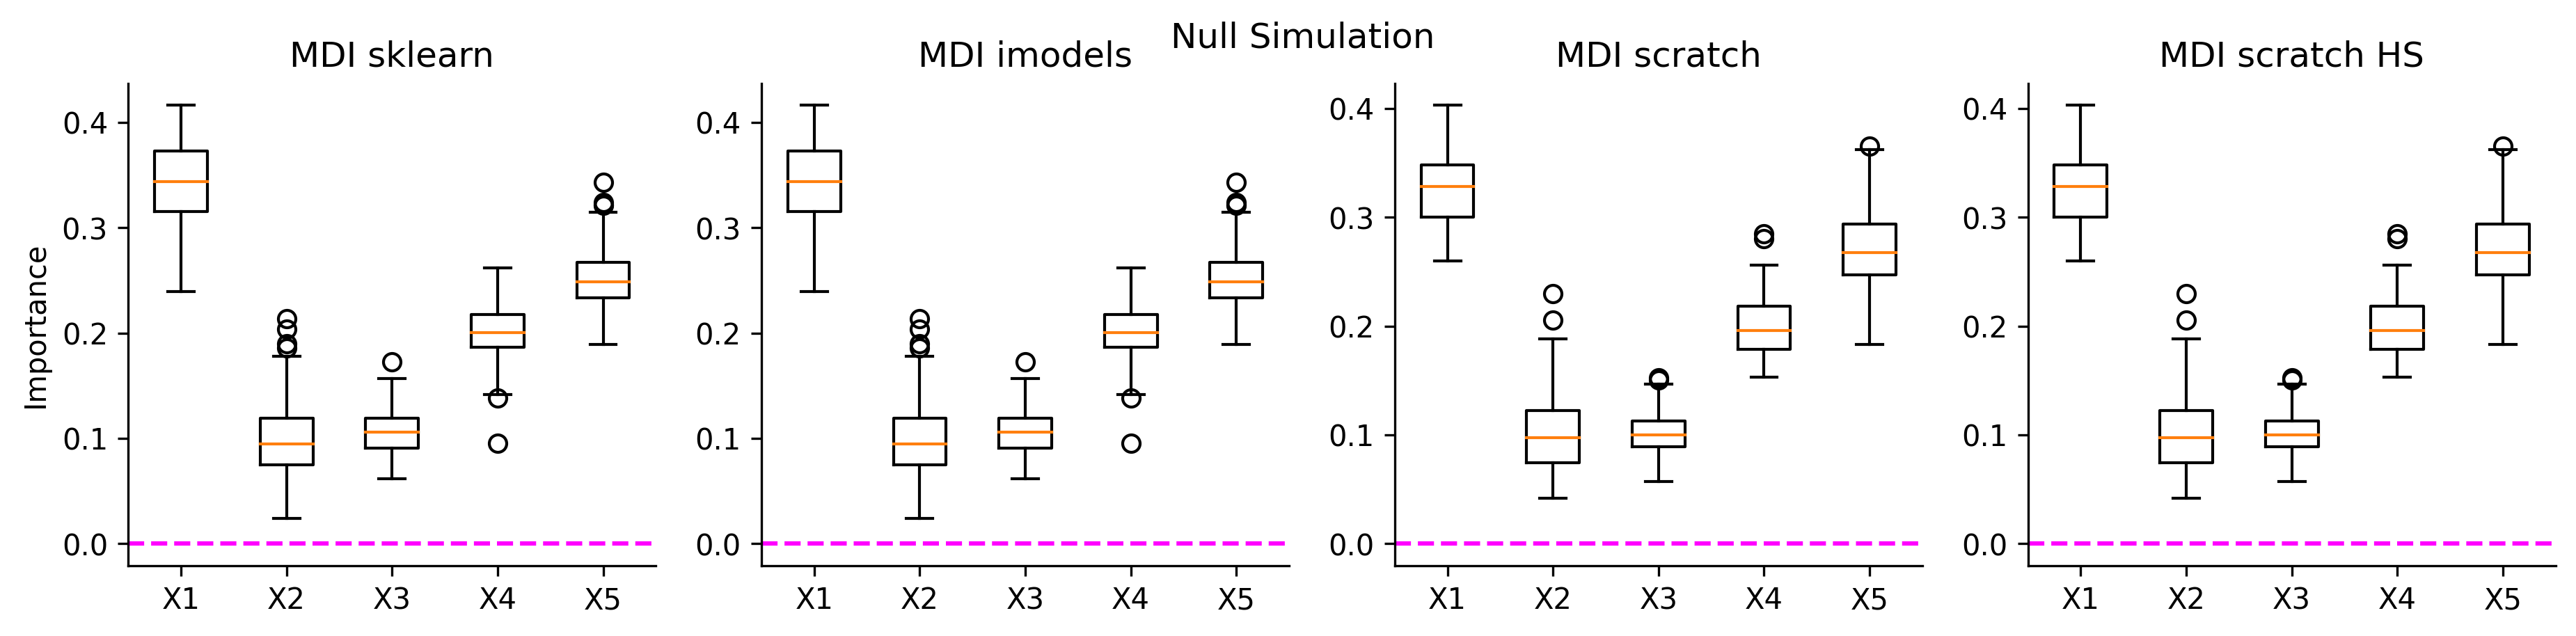

In [59]:
#Null simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,3))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation')           
axs1[0].boxplot(np.array(feat_imps_nullRF[0]), labels=x_label)
axs1[0].axhline(y=0, color='magenta', linestyle='--')
axs1[0].set_title('MDI sklearn')
axs1[0].set_ylabel("Importance")
axs1[1].boxplot(np.array(feat_imps_nullRF[1]), labels=x_label)
axs1[1].axhline(y=0, color='magenta', linestyle='--')
axs1[1].set_title('MDI imodels')
axs1[2].boxplot(np.array(feat_imps_nullRF[2]), labels=x_label)
axs1[2].axhline(y=0, color='magenta', linestyle='--')
axs1[2].set_title('MDI scratch')
axs1[3].boxplot(np.array(feat_imps_nullRF[3]), labels=x_label)
axs1[3].axhline(y=0, color='magenta', linestyle='--')
axs1[3].set_title('MDI scratch HS');

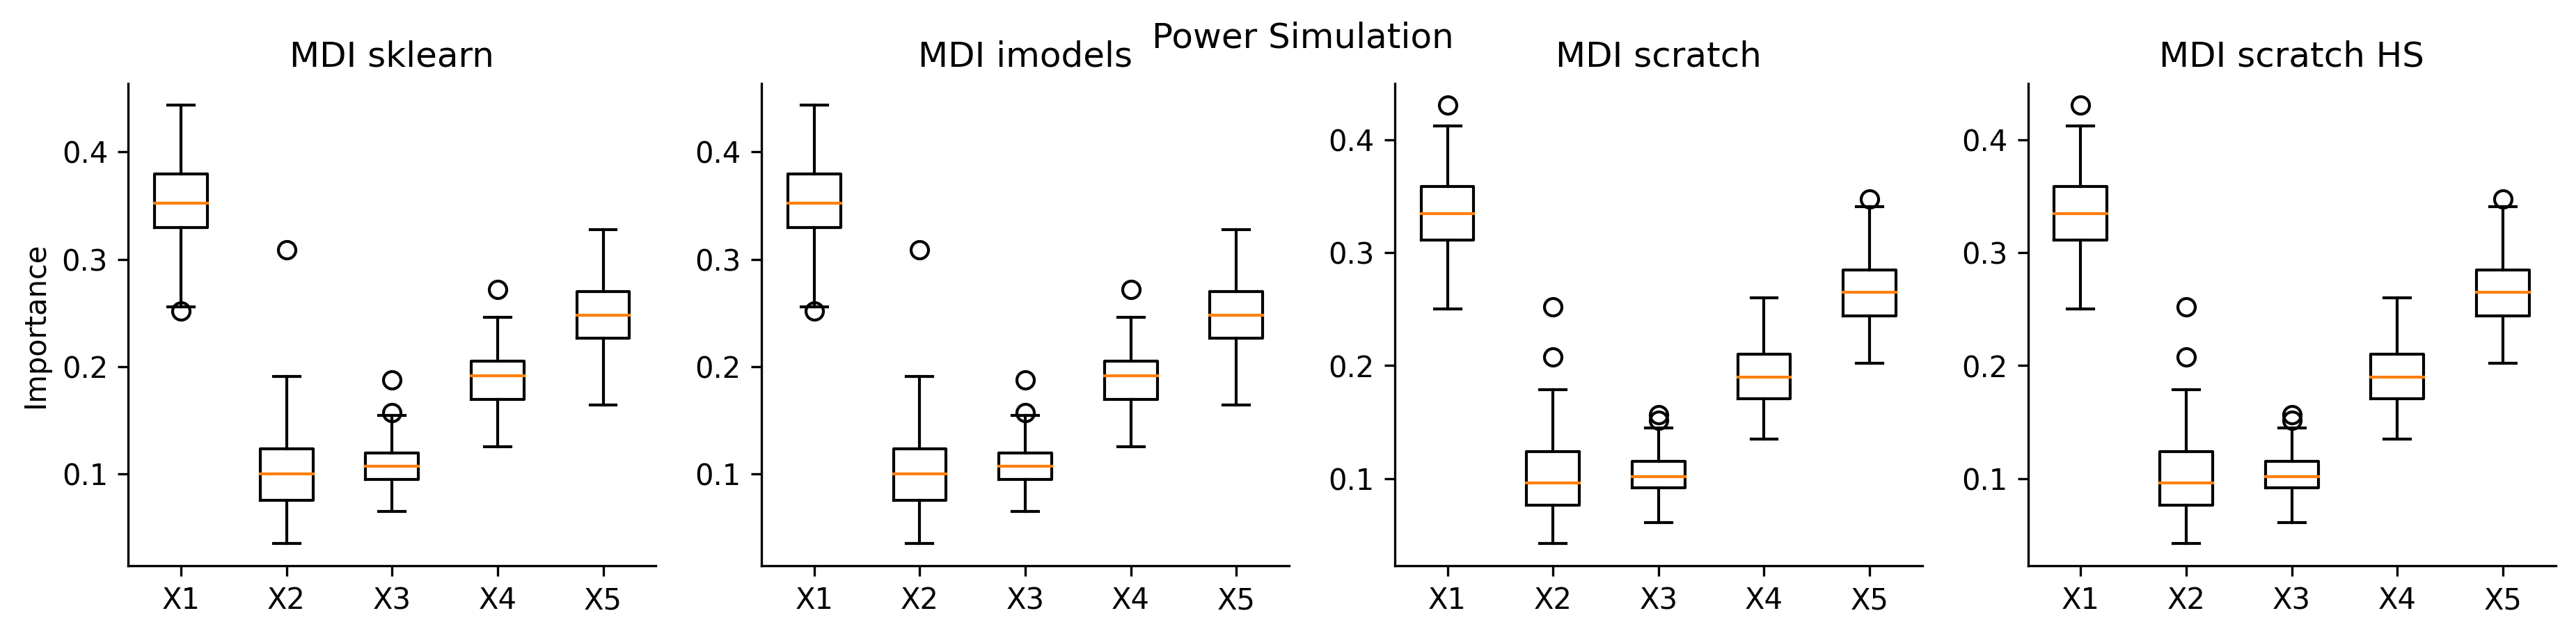

In [60]:
#Power simulation
fig, axs1 = plt.subplots(1,4, figsize=(15,3))

fig.suptitle('Power Simulation')           
axs1[0].boxplot(np.array(feat_imps_powerRF[0]), labels=x_label)
axs1[0].set_title('MDI sklearn')
axs1[0].set_ylabel('Importance')
axs1[1].boxplot(np.array(feat_imps_powerRF[1]), labels=x_label)
axs1[1].set_title('MDI imodels')
axs1[2].boxplot(np.array(feat_imps_powerRF[2]), labels=x_label)
axs1[2].set_title('MDI scratch')
axs1[3].boxplot(np.array(feat_imps_powerRF[3]), labels=x_label)
axs1[3].set_title('MDI scratch HS');

### SHAP

In [65]:
%%time
[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], shap_imps_nullRF, shap_imps_powerRF = simulate_data_simpleRF(
    n_trees=15, imp_score="SHAP", random_seed=42)

CPU times: user 8min 58s, sys: 3.97 s, total: 9min 2s
Wall time: 9min 12s


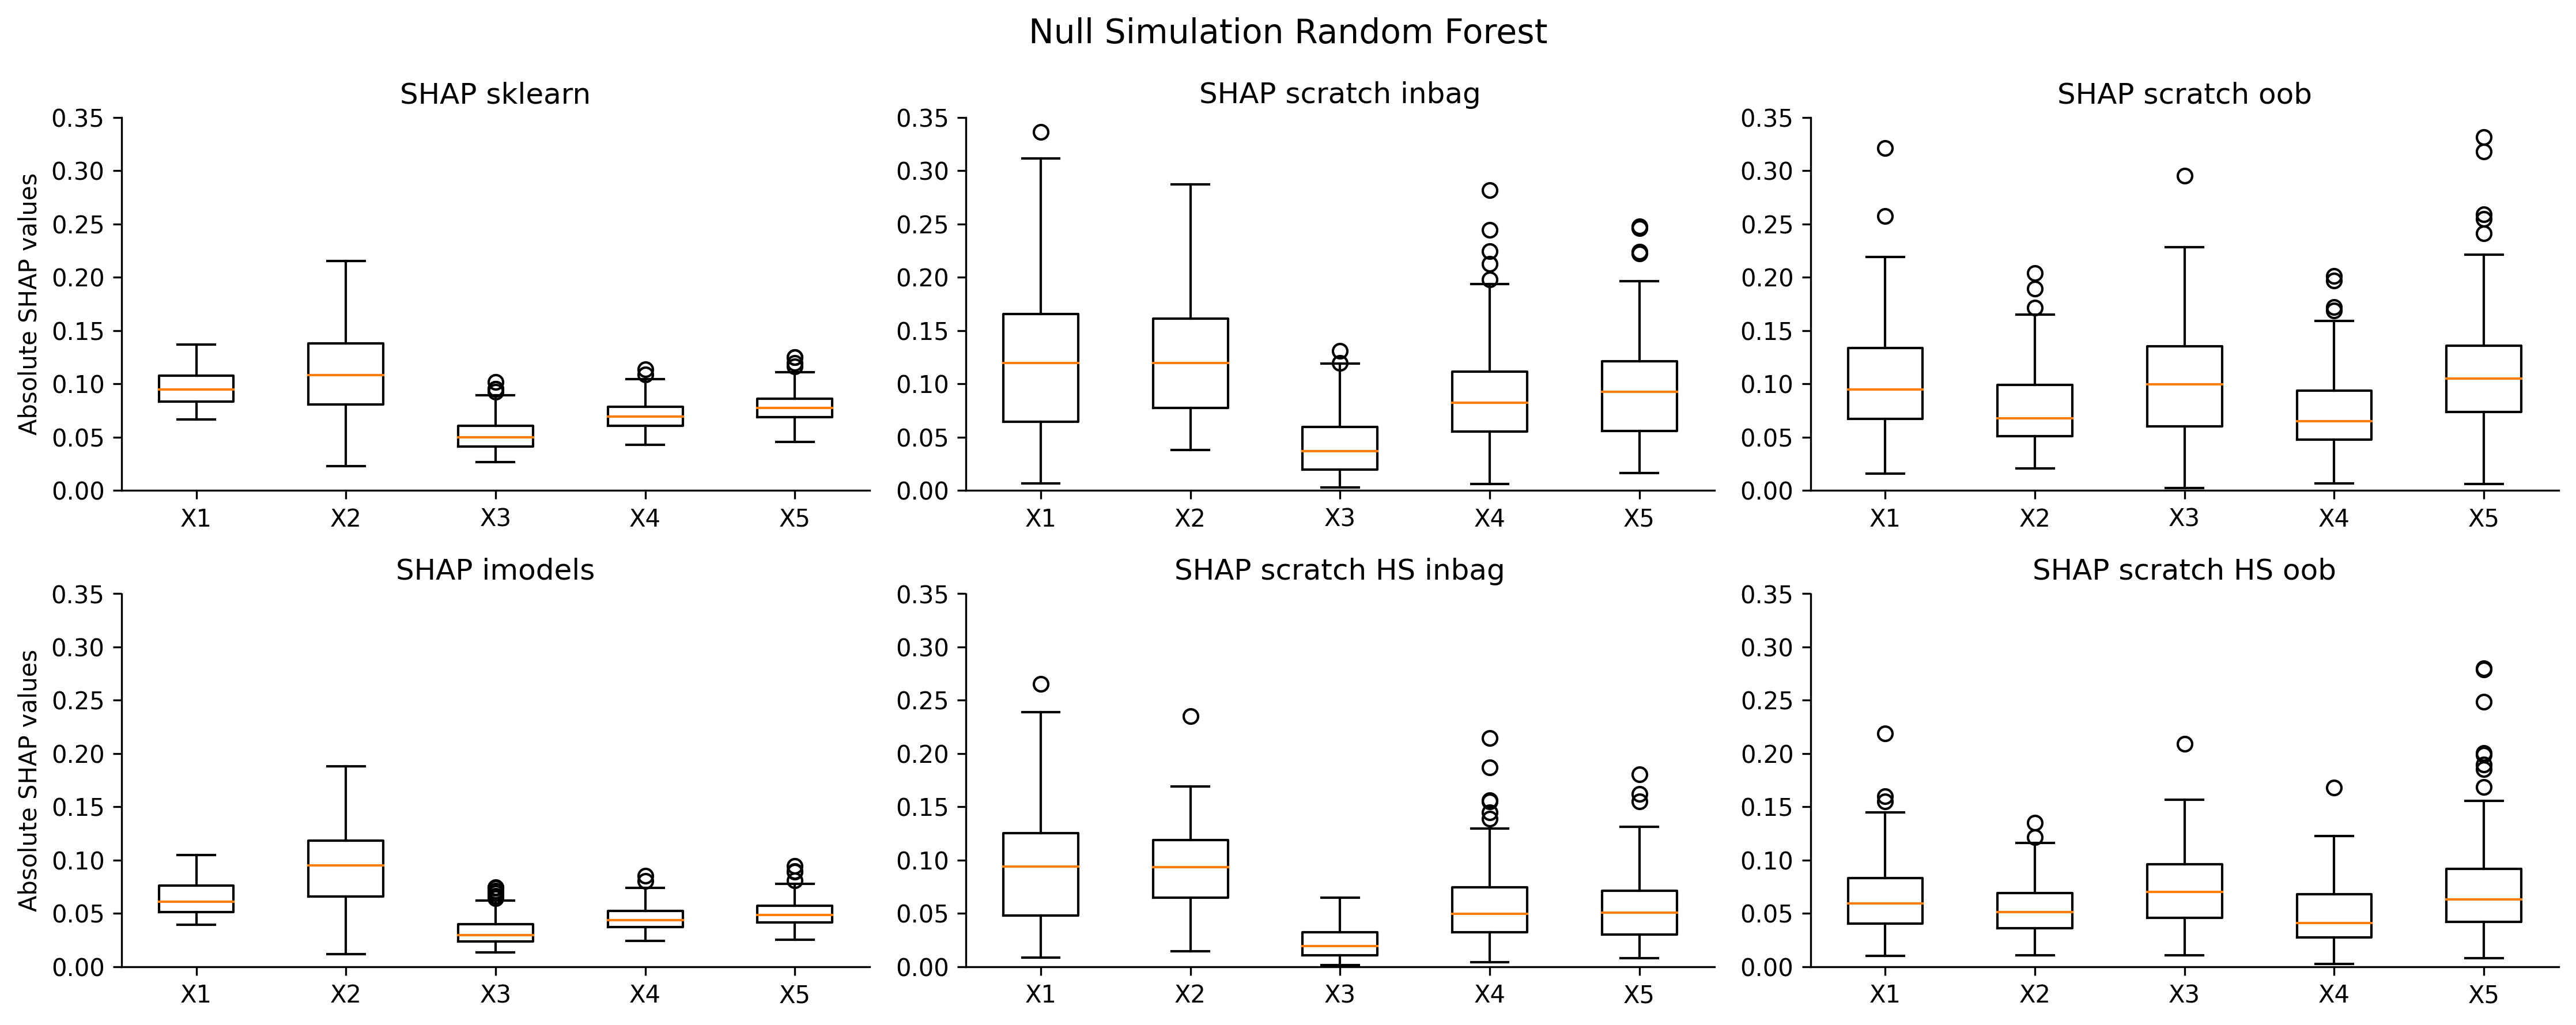

In [157]:
#Null simulation
fig, axs = plt.subplots(2,3, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation Random Forest', fontsize=14)

axs[0,0].boxplot(np.abs(np.array(shap_imps_nullRF[0])).mean(axis=1), labels=x_label)
axs[0,0].set_title('SHAP sklearn')
axs[0,0].set_ylabel("Absolute SHAP values")

axs[0,1].boxplot(np.abs(np.array(shap_imps_nullRF[2][0])).mean(axis=0), labels=x_label)
axs[0,1].set_title('SHAP scratch inbag')

axs[0,2].boxplot(np.abs(np.array(shap_imps_nullRF[2][1])).mean(axis=0), labels=x_label)
axs[0,2].set_title('SHAP scratch oob')

axs[1,0].boxplot(np.abs(np.array(shap_imps_nullRF[1])).mean(axis=1), labels=x_label)
axs[1,0].set_title('SHAP imodels')
axs[1,0].set_ylabel("Absolute SHAP values")

axs[1,1].boxplot(np.abs(np.array(shap_imps_nullRF[3][0])).mean(axis=0), labels=x_label)
axs[1,1].set_title('SHAP scratch HS inbag')

axs[1,2].boxplot(np.abs(np.array(shap_imps_nullRF[3][1])).mean(axis=0), labels=x_label)
axs[1,2].set_title('SHAP scratch HS oob')

plt.setp(axs, ylim=[0,0.35]) #set global ylim for all suplots

fig.tight_layout();

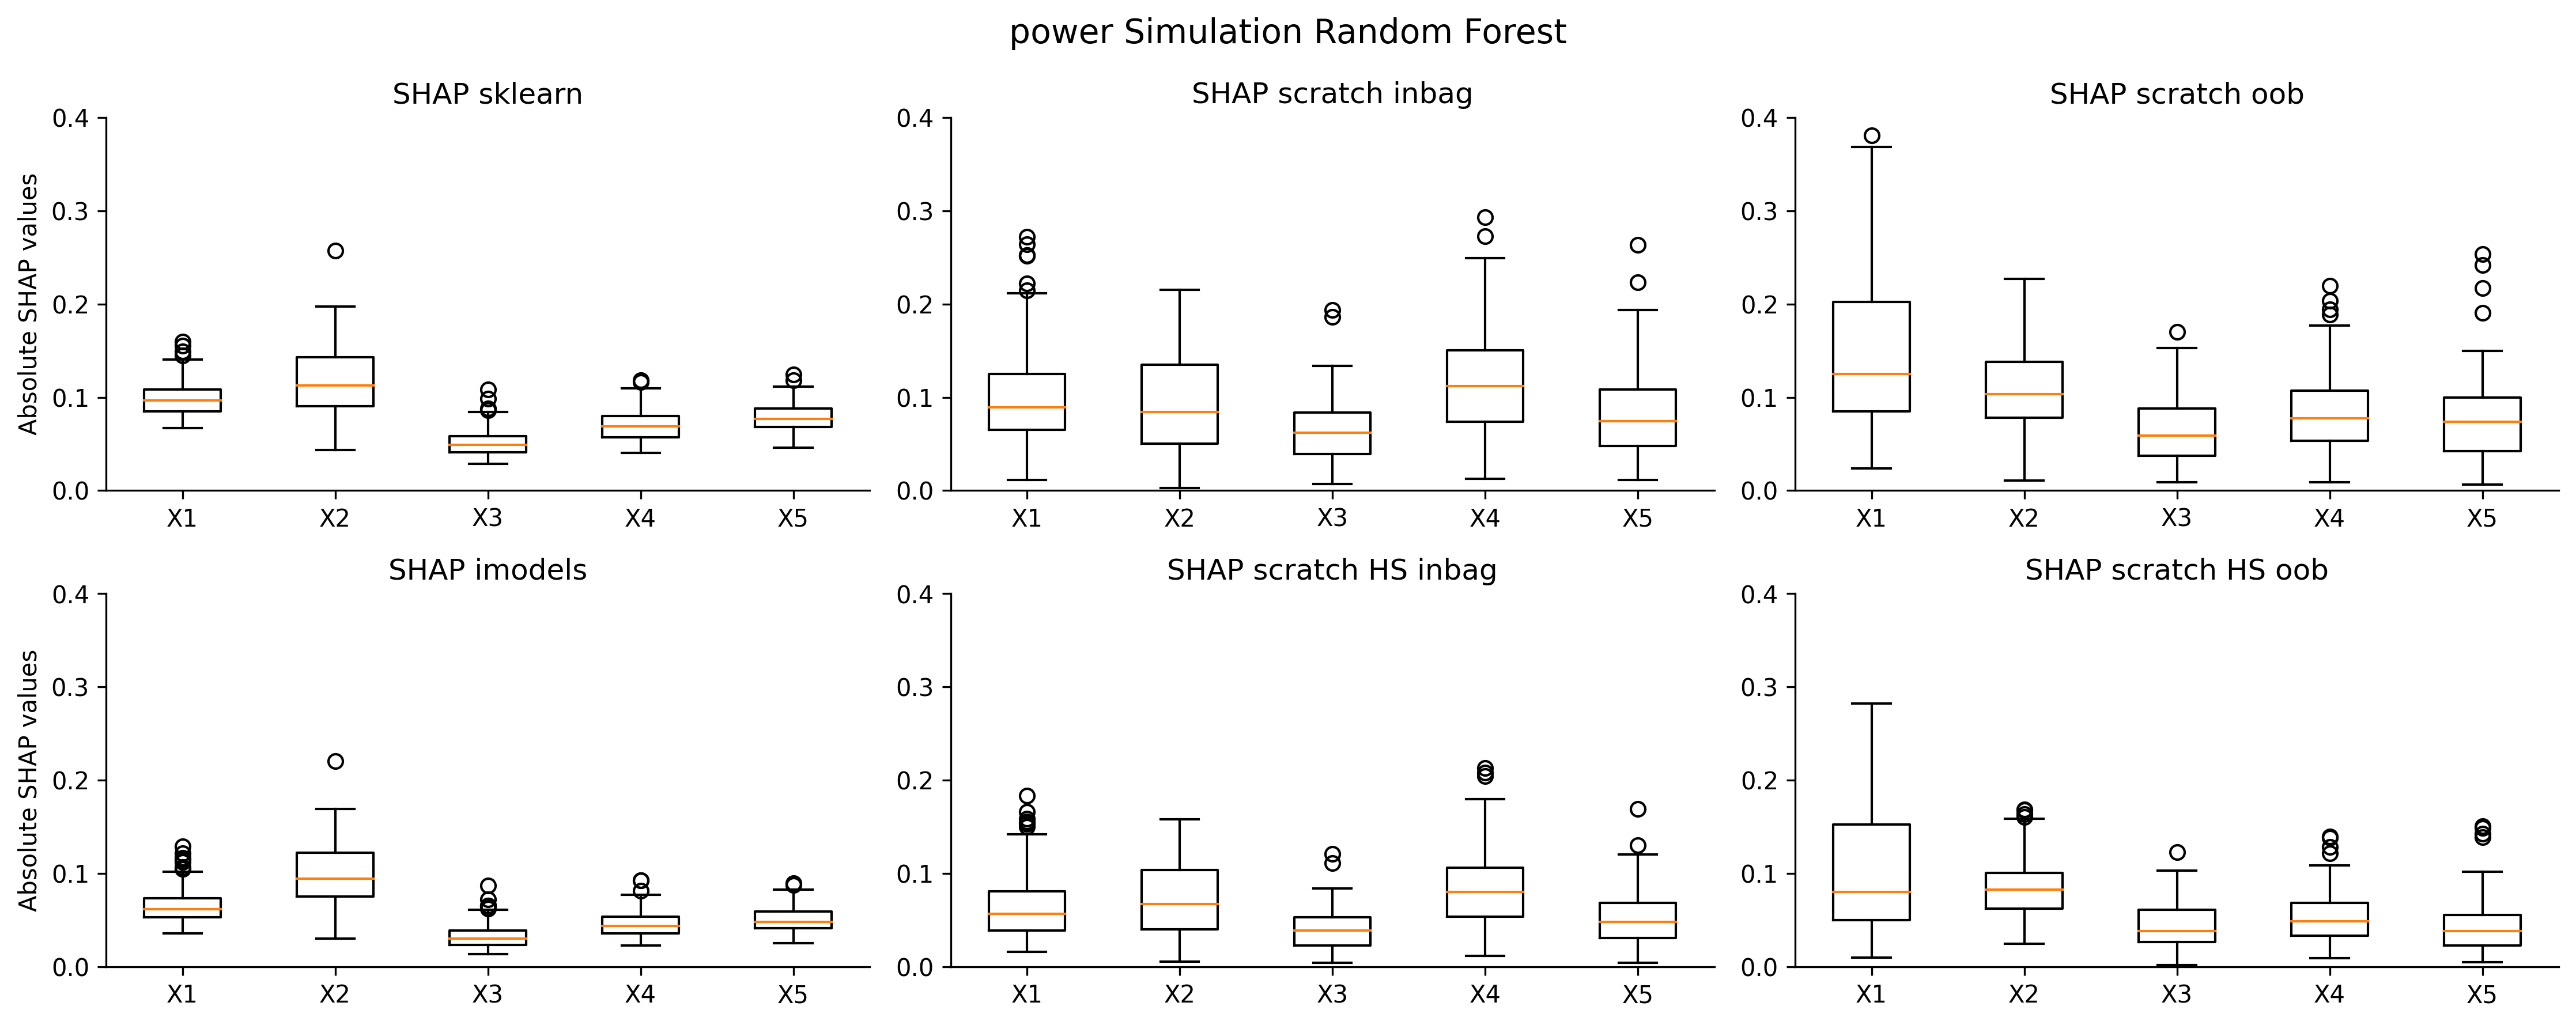

In [89]:
#power simulation
fig, axs = plt.subplots(2,3, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Power Simulation Random Forest', fontsize=14)

axs[0,0].boxplot(np.abs(np.array(shap_imps_powerRF[0])).mean(axis=1), labels=x_label)
axs[0,0].set_title('SHAP sklearn')
axs[0,0].set_ylabel("Absolute SHAP values")

axs[0,1].boxplot(np.abs(np.array(shap_imps_powerRF[2][0])).mean(axis=0), labels=x_label)
axs[0,1].set_title('SHAP scratch inbag')

axs[0,2].boxplot(np.abs(np.array(shap_imps_powerRF[2][1])).mean(axis=0), labels=x_label)
axs[0,2].set_title('SHAP scratch oob')

axs[1,0].boxplot(np.abs(np.array(shap_imps_powerRF[1])).mean(axis=1), labels=x_label)
axs[1,0].set_title('SHAP imodels')
axs[1,0].set_ylabel("Absolute SHAP values")

axs[1,1].boxplot(np.abs(np.array(shap_imps_powerRF[3][0])).mean(axis=0), labels=x_label)
axs[1,1].set_title('SHAP scratch HS inbag')

axs[1,2].boxplot(np.abs(np.array(shap_imps_powerRF[3][1])).mean(axis=0), labels=x_label)
axs[1,2].set_title('SHAP scratch HS oob')

plt.setp(axs, ylim=[0,0.4]) #set global ylim for all suplots

fig.tight_layout();

### Smooth SHAP

In [130]:
%%time
[X_nullRF, y_nullRF], [X_powerRF, y_powerRF], sm_shap_imps_nullRF, sm_shap_imps_powerRF = simulate_data_simpleRF(
    n_trees=15, imp_score="SmoothSHAP", random_seed=42)

CPU times: user 8min 19s, sys: 2.17 s, total: 8min 21s
Wall time: 8min 37s


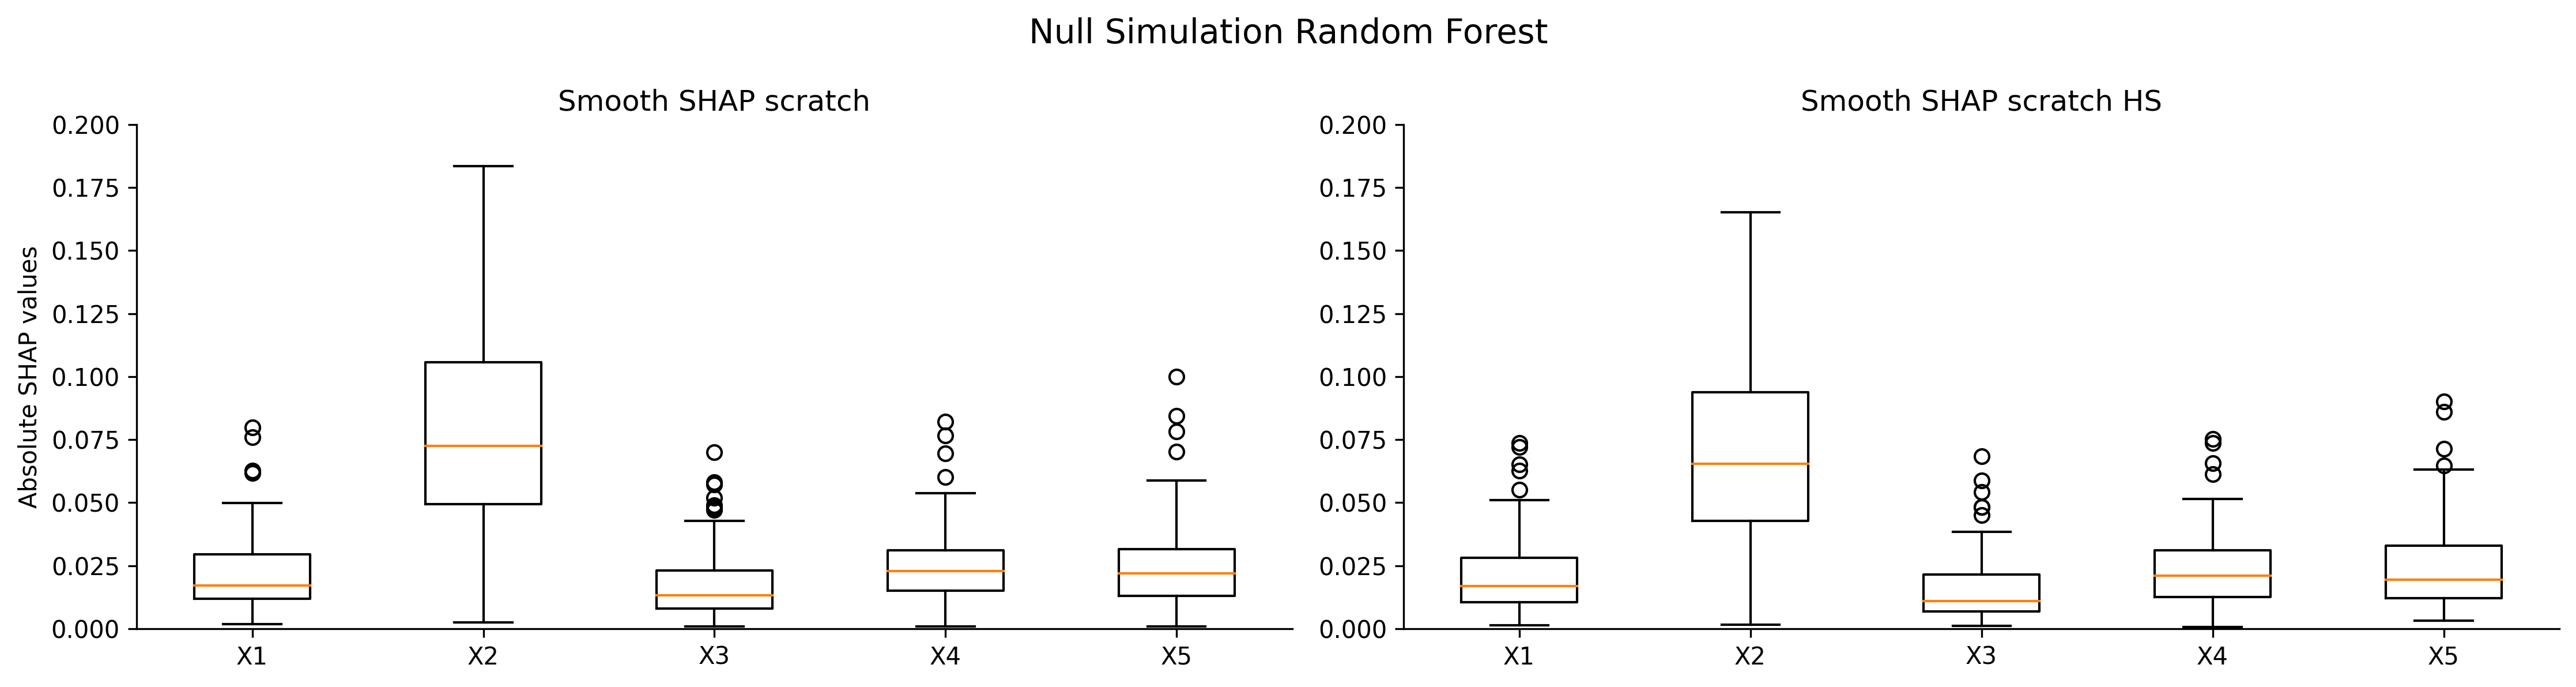

In [155]:
#Null simulation
fig, axs = plt.subplots(1,2, figsize=(15,4))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Null Simulation Random Forest', fontsize=14)


axs[0].boxplot(np.abs(np.array(sm_shap_imps_nullRF[2])).mean(axis=1), labels=x_label)
axs[0].set_title('Smooth SHAP scratch')
axs[0].set_ylabel("Absolute SHAP values")

axs[1].boxplot(np.abs(np.array(sm_shap_imps_nullRF[3])).mean(axis=1), labels=x_label)
axs[1].set_title('Smooth SHAP scratch HS')

plt.setp(axs, ylim=[0,0.2]) #set global ylim for all suplots

fig.tight_layout();

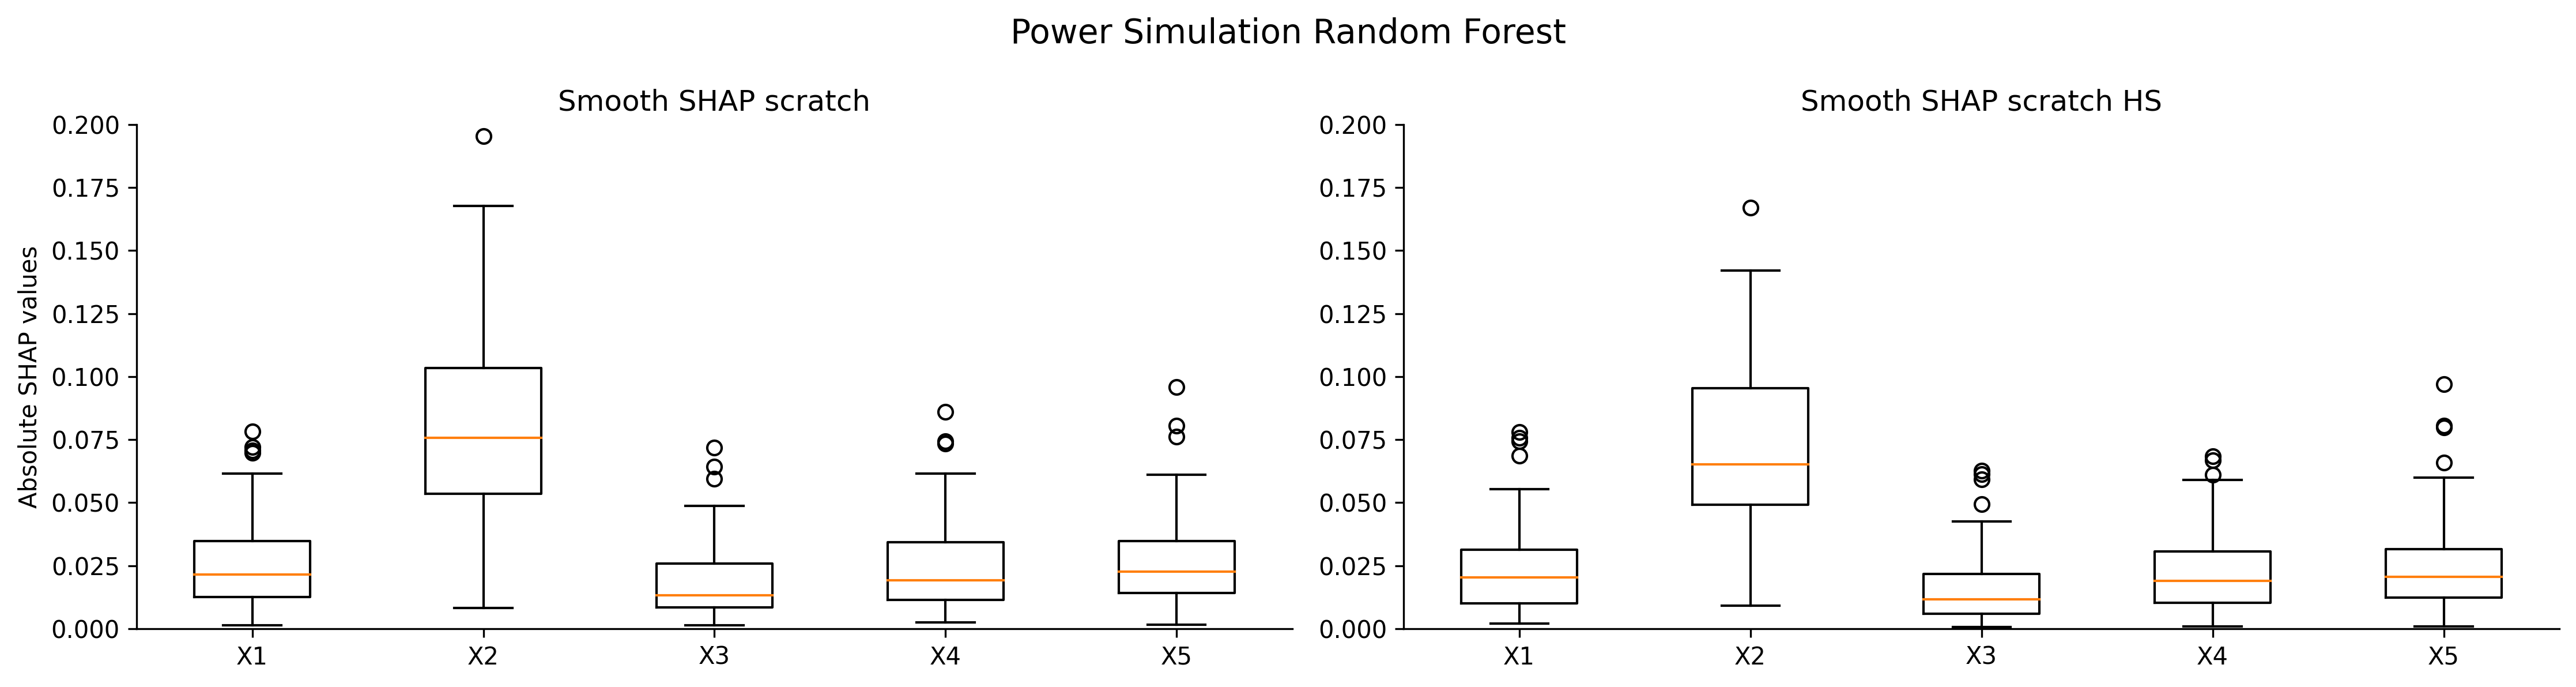

In [156]:
#power simulation
fig, axs = plt.subplots(1,2, figsize=(15,4))
x_label = ["X1", "X2", "X3", "X4", "X5"]

fig.suptitle('Power Simulation Random Forest', fontsize=14)


axs[0].boxplot(np.abs(np.array(sm_shap_imps_powerRF[2])).mean(axis=1), labels=x_label)
axs[0].set_title('Smooth SHAP scratch')
axs[0].set_ylabel("Absolute SHAP values")

axs[1].boxplot(np.abs(np.array(sm_shap_imps_powerRF[3])).mean(axis=1), labels=x_label)
axs[1].set_title('Smooth SHAP scratch HS')

plt.setp(axs, ylim=[0,0.2]) #set global ylim for all suplots

fig.tight_layout();